In [1]:
import matplotlib.pyplot as plt
from datasets.PupilCoreDatasetPupil import PupilCoreDataset
import torch
from eye_model import EyeModeling
from torchvision.models.segmentation import FCN_ResNet50_Weights, fcn_resnet50
import numpy as np
import utils
from models.ifOpened import ifOpenedModel
from models.trainers import PupilSegmentationTrainer, IfOpenedTrainer
from visualization.visualise_pupil import draw_normal_vectors_2D

In [2]:
DATASET_LEN_TO_USE = 5000
dataset = PupilCoreDataset(
    "datasets/PupilCoreDataset/video5_eye0_video.avi",
    'datasets/PupilCoreDataset/video5_eye0_pupildata.csv',
    "datasets/PupilCoreDataset/video5_eye1_video.avi",
    'datasets/PupilCoreDataset/video5_eye1_pupildata.csv',
    DATASET_LEN_TO_USE
)
# dataset.get_pupil_ellipse()
# dataset.save_masks("datasets/PupilCoreDataset/created_masks")

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
ifOpenedModel = ifOpenedModel()
PupilSegmentationModel = fcn_resnet50(weights=None, num_classes=1)

c:\Users\Admin\Desktop\inzynierka\my_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\Desktop\inzynierka\my_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
dataset.load_masks("datasets/PupilCoreDataset/created_masks/eye0", "datasets/PupilCoreDataset/created_masks/eye1")

In [6]:
torch.set_printoptions(edgeitems=100)


In [7]:
if_opened_trainer = IfOpenedTrainer(model=ifOpenedModel, dataset=dataset, dataset_len=DATASET_LEN_TO_USE)
pupil_trainer = PupilSegmentationTrainer(model=PupilSegmentationModel, dataset=dataset, dataset_len=DATASET_LEN_TO_USE)

In [8]:
# dataset_pupil.get_pupil_ellipse()

In [9]:
# pupil_trainer.train(device=device, num_epochs=5)

In [10]:
# pupil_trainer.train(device=device, num_epochs=5)
pupil_trainer.model.load_state_dict(torch.load("models/weights/resnet50.pt"))


<All keys matched successfully>

In [11]:
def visualize_mask(image, mask):
    with torch.no_grad():
        pupil_trainer.model.eval()
        pupil_trainer.model = pupil_trainer.model.to(device)
        for i, (inputs, masks, opened) in enumerate(pupil_trainer.dataloaders['test']):

            inputs = inputs.to(device)
            outputs = pupil_trainer.model(inputs)


            image = np.transpose(inputs[0].cpu().numpy(), (1, 2, 0)).copy()
            outputs_sig = torch.sigmoid(outputs['out'][0])
            outputs_sig = np.transpose(outputs_sig.cpu().numpy(), (1, 2, 0)).copy()

            # visualize_pupil(image, outputs_sig)
            ellipse = utils.fit_ellipse(outputs_sig)
            print(ellipse)
            break



In [12]:
# TODO zmierzyc focal_len na obrazkach w pikselach
# trzeba zebrac obrazki gdzie oko patrzy w miare prosto

estimate_radius_in_px = utils.get_pupil_radius_from_masks(dataset.eye0_masks)


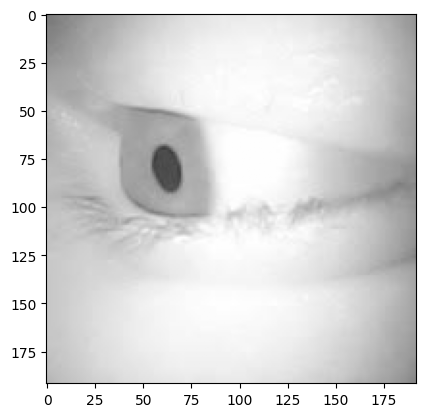

TypeError: Invalid shape (1, 1, 192, 192) for image data

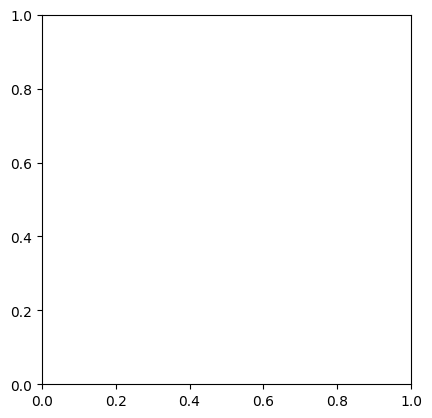

In [18]:
# TODO swirski test
focal_len = 140 # ??? taken from https://github.com/pupil-labs/pupil/blob/master/pupil_src/shared_modules/camera_models.py Pupil Cam3
image_shape = (192, 192)
inital_eye_center_z = estimate_radius_in_px*40
eye_modeling = EyeModeling(focal_len=focal_len, pupil_radius=estimate_radius_in_px, image_shape=image_shape, inital_z=inital_eye_center_z)

with torch.no_grad():
    pupil_trainer.model.eval()
    pupil_trainer.model = pupil_trainer.model.to(device)
    for i, (inputs, masks, opened) in enumerate(pupil_trainer.dataloaders['test']):

        inputs = inputs.to(device)
        outputs = pupil_trainer.model(inputs)

        image = np.transpose(inputs[0].cpu().numpy(), (1, 2, 0)).copy()
        outputs_sig = torch.sigmoid(outputs['out'][0])
        outputs_sig = np.transpose(outputs_sig.cpu().numpy(), (1, 2, 0)).copy()
        plt.imshow(image)
        plt.show()
        plt.imshow(masks)
        plt.show()

    #     ellipse = utils.fit_ellipse(outputs_sig)
    #     if ellipse:
    #         eye_modeling.two_circle_unprojection(ellipse)

    #         vec_img = draw_normal_vectors_2D(image, eye_modeling.disc_centers[i][0][0:2], eye_modeling.disc_normals[i][0][0:2], color=(0,0,255))
    #         vec_img = draw_normal_vectors_2D(image, eye_modeling.disc_centers[i][1][0:2], eye_modeling.disc_normals[i][1][0:2], color=(255,0,0))
    #         plt.imshow(vec_img)
    #         plt.show()

        if i > 5:
            break
    
    # eye_modeling.sphere_centre_estimate()
    # print(eye_modeling.estimated_eye_center)
    # eye_modeling.sphere_radius_estimate()
    
    

In [ ]:
#TODO 2 NN system
